In [1]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, WeightedRandomSampler
from PIL import Image
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report



In [2]:
### applying here for the data augmentation techniques 
#* for the grayscale to be  output of channels of 3 it was required to pretrained cnn model, So we make fake grayscale ouput channels
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [3]:
data_dir = './Data/chest x-ray'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
print(f'training data: {len(train_dataset)}')
print(f'validation data: {len(val_dataset)}')
print(f'test data: {len(test_dataset)}')


training data: 7200
validation data: 390
test data: 881


In [4]:
#* method for getting the classes disribution 

def get_class_distribution(dataset): 
    counter_pr_class = Counter([dataset.classes[label] for _, label in dataset.imgs])
    return counter_pr_class   
train_distribution = get_class_distribution(train_dataset)
#print(train_distribution)
#* here i am applying the oversample technique 
sample_weights = [1.0 / train_distribution[train_dataset.classes[label]] for _, label in train_dataset.imgs]
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)
#* applying weight random to 
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights)*3, replacement=True)
print(len(sampler))
sample_labels = [train_dataset.classes[train_dataset.targets[i]] for i in list(sampler)]
sampled_distribution = Counter(sample_labels)

21600


In [5]:
#* for the dateset loaders 
train_loader = DataLoader(train_dataset, sampler=sampler,  batch_size= 32, num_workers=4)
val_loader = DataLoader(val_dataset,  batch_size=32, num_workers=4, shuffle=False )
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)

dataiter = iter(train_loader)
imgs, labels = next(dataiter)
print(imgs.shape)
print(torch.min(imgs), torch.max(imgs))
print(f'images shapes: {imgs.shape}')


torch.Size([32, 3, 224, 224])
tensor(-1.) tensor(1.)
images shapes: torch.Size([32, 3, 224, 224])


In [6]:
#* device type in this scanario using for amc 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


#* defining the pretrained Resnet18 
model = models.resnet18()
num_classes = len(train_dataset.classes)
#* modifying the final fully connected to mu
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)




In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.0001, weight_decay=1e-5)


In [8]:
def train(model, train_loader, criterion, optimizer, device): 
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    avg_train_loss = running_loss / len(train_loader)
    avg_train_acc = 100 * correct / total
    return avg_train_loss, avg_train_acc

In [9]:
def validation(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_val_loss = running_loss / len(val_loader)
    avg_val_acc = 100 * correct / total
    return avg_val_loss, avg_val_acc

In [10]:
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validation(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")


Epoch [1/10] Train Loss: 0.4148, Train Acc: 84.18, Val Loss: 0.8226, Val Acc: 71.79
Epoch [2/10] Train Loss: 0.1823, Train Acc: 93.44, Val Loss: 0.5016, Val Acc: 81.03
Epoch [3/10] Train Loss: 0.1245, Train Acc: 95.61, Val Loss: 0.1597, Val Acc: 94.10
Epoch [4/10] Train Loss: 0.1003, Train Acc: 96.45, Val Loss: 0.2501, Val Acc: 91.03
Epoch [5/10] Train Loss: 0.0772, Train Acc: 97.31, Val Loss: 0.1338, Val Acc: 95.38
Epoch [6/10] Train Loss: 0.0687, Train Acc: 97.64, Val Loss: 0.1067, Val Acc: 95.64
Epoch [7/10] Train Loss: 0.0580, Train Acc: 97.97, Val Loss: 0.1957, Val Acc: 92.82
Epoch [8/10] Train Loss: 0.0538, Train Acc: 98.20, Val Loss: 0.1042, Val Acc: 96.41
Epoch [9/10] Train Loss: 0.0492, Train Acc: 98.35, Val Loss: 0.1257, Val Acc: 96.67
Epoch [10/10] Train Loss: 0.0410, Train Acc: 98.64, Val Loss: 0.2023, Val Acc: 92.31


In [11]:
#* model  evaluation 
def evaluation (model, test_loader,  criterion, device ):
    test_loss = 0.0;
    all_pred, all_labels = [], []
    correct = 0;
    total = 0; 
    model.eval();  
    with torch.no_grad(): 
        
        for inputs, labels in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            test_loss += loss.item(); 
            _, predict = torch.max(outputs, 1); 
            total += labels.size(0); 
            correct += (predict==labels).sum().item()
            all_pred.extend(predict.cpu().numpy())
            all_labels.extend(labels.cpu().numpy());
            result_test_loss = test_loss / len(test_loader); 
            result_test_acc = 100 * correct / total; 
    return result_test_loss, result_test_acc, all_pred, all_labels; 
          

In [12]:
test_loss,  test_acc, all_preds, all_labels = evaluation(model, test_loader, criterion, device)
print(f'The Restnet 18 performance: Test loss:  {test_loss:.4f} Accuracy: {test_acc}')


The Restnet 18 performance: Test loss:  0.7790 Accuracy: 82.17934165720771


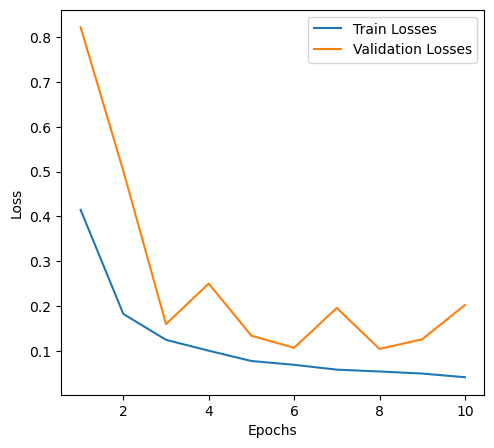

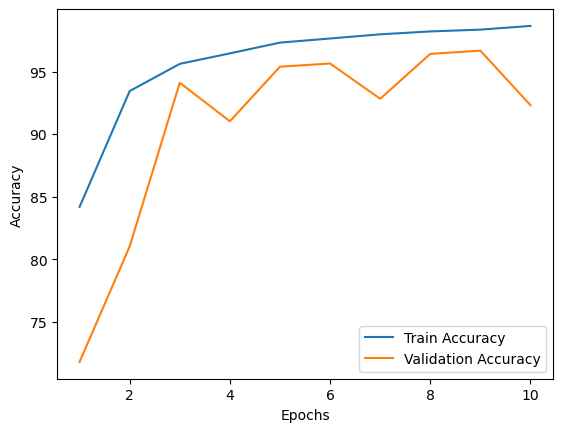

In [13]:
def plot_metrics(train_losses, train_accs, val_losses, val_accs): 
    
    num_epochs  = range(1, len(train_losses)+1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(num_epochs,  train_losses, label = 'Train Losses')
    plt.plot(num_epochs, val_losses, label='Validation Losses')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.show()
    
    plt.plot(num_epochs, train_accs, label= 'Train Accuracy')
    plt.plot(num_epochs, val_accs, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    

plot_metrics(train_losses, train_accs, val_losses, val_accs)

Accuracy: 0.8217934165720772

 classification Report
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       108
           1       0.84      0.94      0.88        98
           2       0.48      0.97      0.65       116
           3       0.99      0.77      0.86       504
           4       1.00      0.75      0.85        55

    accuracy                           0.82       881
   macro avg       0.84      0.86      0.82       881
weighted avg       0.89      0.82      0.84       881



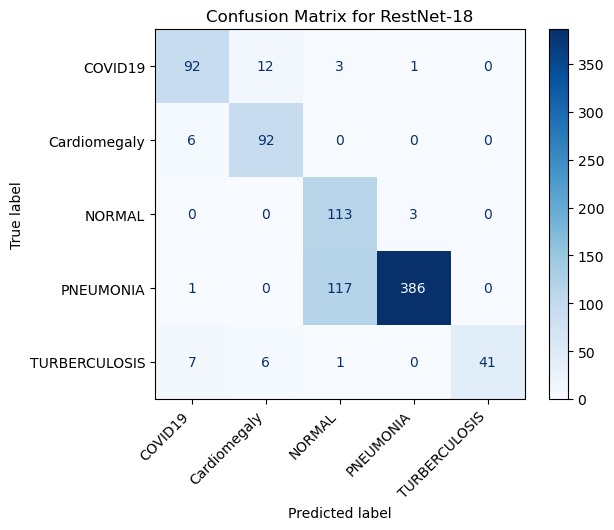

In [14]:
#* confusion metrics 


accuracy = accuracy_score(all_preds, all_labels)
print(f"Accuracy: {accuracy}")
print('\n classification Report')
cls_report = classification_report(all_preds, all_labels)
print(cls_report)

cm = confusion_matrix(all_preds, all_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
display.plot(cmap='Blues')
plt.xticks(rotation = 45, ha= 'right')
plt.title('Confusion Matrix for RestNet-18')
plt.show()
